# 16 MeV D on Ta 

This notebook documents the steps taken to calibrate, aquire, and analyse data from activation foils used to unfold the neutron spectrum from 16 MeV D breakup on Ta.  

## Calibration

### Import source data

Calibration was performed using Cs137, Co60, Eu 152, Am241, and Ba133 sources. The lines used for energy and efficiency calibration are:

Source   | Line (keV)| BR [%]
-------- |:---------:|:------:
Cs137    |661.657    |85.10
Cs60     |1173.23    |99.85
Cs60     |1332.49    |99.98
Eu152    |121.70     |20.56
Eu152    |244.70     |5.44
Eu152    |344.29     |7.42
Eu152    |778.90     |3.61
Eu152    |964.06     |10.46
Eu152    |1112.08    |9.85
Eu152    |1408.01    |15.04
Am241    |59.54      |2.14
Ba133    |276.40     |7.16
Ba133    |356.01     |62.05

This data, along with the initial activity and decay information, is also located in the excel file located here:

In [1]:
calibSourcesPath='CalibrationSources.xlsx'

Import the source and activity data and format for later analysis:

In [2]:
import os
import sys
import peakutils

import pandas as pd
import numpy as np
import copy as cp

from math import sqrt, exp, log
from datetime import datetime
from scipy.optimize import curve_fit
from peakutils.plot import plot as pplot
from matplotlib import pyplot
%matplotlib inline

# Path to support functions 
sys.path.insert(0,os.path.abspath('/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/GeneralNuclear'))
from Counting import parse_spe, peak_counts, germanium_rel_eff
from BasicNuclearCalcs import decay

In [3]:
sources = pd.read_excel(calibSourcesPath,"Sources")
sources.columns=['source','initActivity','initDate','halfLife']
sources.index=sources.source
del sources['source']
sources['initDate'] = pd.to_datetime(sources['initDate'])
sources['measDate']=0     

print "The calibration source data used: \n\n", sources

The calibration source data used: 

        initActivity   initDate     halfLife  measDate
source                                                
Am241         10.300 1970-01-01  13644204000         0
Eu152          1.062 2009-01-01    426326180         0
Co60           1.007 2009-01-01    166344192         0
Cs137          1.042 2009-01-01    948723200         0
Ba133          1.078 2009-01-01    332778540         0


Import the calibration line and branching ratio data:

In [4]:
lines = pd.read_excel(calibSourcesPath,"Lines")
lines.columns=['isotope','line','branchingRatio']
print "The calibration peak data used: \n\n", lines

The calibration peak data used: 

      isotope       line  branchingRatio
0   Cs137       661.6570        0.851000
1   Co60       1173.2300        0.998500
2   Co60       1332.4900        0.999826
3   Eu152       121.7000        0.285300
4   Eu152       244.7000        0.075500
5   Eu152       344.2900        0.265900
6   Eu152       778.9000        0.129300
7   Eu152       964.0600        0.145100
8   Eu152      1112.0800        0.136700
9   Eu152      1408.0100        0.208700
10  Ba133        80.9979        0.329000
11  Ba133       276.4000        0.071600
12  Ba133       356.0100        0.620500


### Perform software energy calibration

The energy calibration was performed using GammaVision.

[insert calibration procedure here]

### Read in the calibration data

Read in all of the data taken for calibration.  

This procedure assumes: <br/>
1) That there is a folder with only calibration data in the format "isotope_position_anything.Spe".  For example, a valid naming convention is "Co60_1_8Feb17.Spe".  The first field is used to compare against the imported lines, and the second field is to build a location dependent calibration. <br/>
2) Only calibration data lives in the calibration path specified.  <br/>
5) That the calibration order listed above in the table was followed. <br/>

The path the calibration data is:

In [5]:
calibDataPath='/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Unfolding/Experiments/Activation/16MeVTa/CalibrationData/'

# Variables to allow for multiple positions to be handled at once
posSet=False
posUsed=[]

# Storage for parameters that vary by position
liveTime={}
eCalibParams={} #ax^2 +bx + c stored as (a,b,c)
data={}

# Loop over all files
for filename in os.listdir(calibDataPath):
    if filename.endswith(".Spe"): 
        name = os.path.splitext(filename)[0]
        
        # Read data from this file
        print "Processing:", filename
        (time,measDate,a,b,c,tmpData)=parse_spe(calibDataPath+filename)
        
        # Determine position, update data structures if necessary, and store data
        position=int(name.split('_')[1])
        if position not in posUsed:
            posUsed.append(position)
            liveTime[position]={}
            data[position]=tmpData
            data[position].columns=[name.split('_')[0]]
        else: 
            data[position].loc[:,name.split('_')[0]]=tmpData['counts']
        sources.at[name.split('_')[0],'measDate']=measDate
        liveTime[position][name.split('_')[0]]=time
        if name.split('_')[0]=="Ba133":
            eCalibParams[position]=(a,b,c)
                
for p in posUsed:
    print "\nPosition = {} cm".format(p)
    print "LiveTime:", liveTime[p]
    print "Energy Calibration: {}*ch^2 + {} * ch + {}".format(eCalibParams[p][0],eCalibParams[p][1],eCalibParams[p][2])
    print data[p].head(3)

Processing: Eu152_1.Spe
Processing: Co60_10.Spe
Processing: Ba133_1.Spe
Processing: Co60_1.Spe
Processing: Cs137_1.Spe
Processing: Am241_1.Spe
Processing: Ba133_10.Spe
Processing: Eu152_10.Spe
Processing: Cs137_10.Spe

Position = 1 cm
LiveTime: {'Co60': 60.0, 'Cs137': 60.0, 'Ba133': 120.0, 'Am241': 120.0, 'Eu152': 120.0}
Energy Calibration: 3.468863e-08*ch^2 + 0.3838918 * ch + 0.1874105
      Eu152     Ba133      Co60     Cs137     Am241
0         0         0         0         0         0
1         0         0         0         0         0
2         0         0         0         0         0

Position = 10 cm
LiveTime: {'Co60': 120.0, 'Cs137': 120.0, 'Ba133': 120.0, 'Eu152': 120.0}
Energy Calibration: 3.468863e-08*ch^2 + 0.3838918 * ch + 0.1874105
       Co60     Ba133     Eu152     Cs137
0         0         0         0         0
1         0         0         0         0
2         0         0         0         0


### Calculate the peak counts

Determine the peak area for each of the lines considered.  Save the data in the lines dataframe. 

This procedure assumes: <br/>
1) That no significant background is present.  No background subtraction is performed. <br/>
2) A linear interpolation of the continuum is sufficient.  <br/>


------------------------
Position = 1 cm
------------------------

Eu152 
Energy  Counts     Area
121.88   27188   94977.00
244.74   3669   13605.00
344.18   12039   49927.00
778.86   2071   11435.00
963.97   1413   9041.00
1112.23   1141   7721.00
1408.00   1157   9503.00




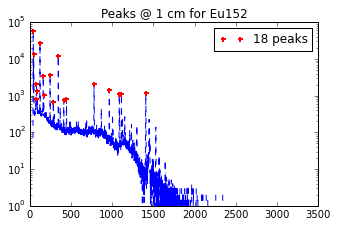


Ba133 
Energy  Counts     Area
80.81   36568   115385.00
276.61   2855   10779.00
356.08   22186   86281.00




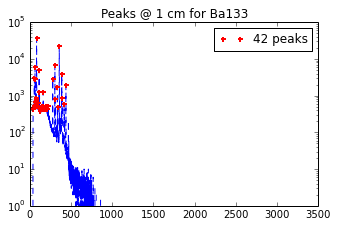


Co60 
Energy  Counts     Area
1173.30   2340   17229.00
1332.33   1859   15254.00




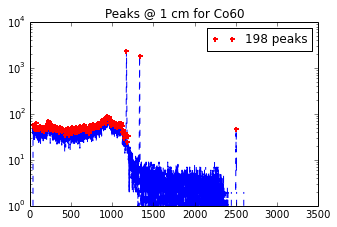


Cs137 
Energy  Counts     Area
661.74   12765   65901.00




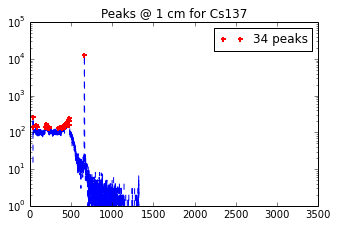


Am241 
Energy  Counts     Area




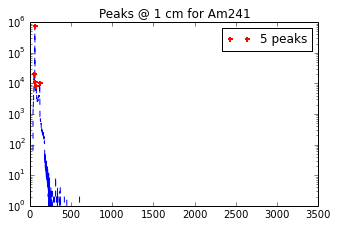

   isotope       line  branchingRatio  measuredCounts  measUncert
0    Cs137   661.6570        0.851000           65901         257
1     Co60  1173.2300        0.998500           17229         135
2     Co60  1332.4900        0.999826           15254         125
3    Eu152   121.7000        0.285300           94977         320
4    Eu152   244.7000        0.075500           13605         130
5    Eu152   344.2900        0.265900           49927         231
6    Eu152   778.9000        0.129300           11435         118
7    Eu152   964.0600        0.145100            9041         105
8    Eu152  1112.0800        0.136700            7721          97
9    Eu152  1408.0100        0.208700            9503         100
10   Ba133    80.9979        0.329000          115385         352
11   Ba133   276.4000        0.071600           10779         112
12   Ba133   356.0100        0.620500           86281         297

------------------------
Position = 10 cm
------------------------

Co60 
E

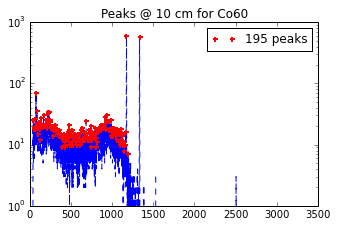


Ba133 
Energy  Counts     Area
81.19   5019   14126.00
276.61   532   1703.00
356.08   3271   12097.00




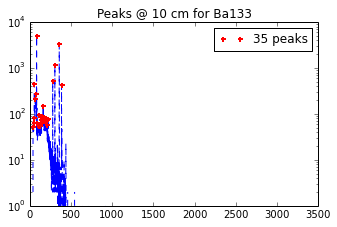


Eu152 
Energy  Counts     Area
121.88   4375   12334.00
244.74   697   2285.00
344.57   1613   5952.00
778.86   324   1508.00
963.97   233   1334.00
1112.61   195   1167.00
1408.00   199   1422.00




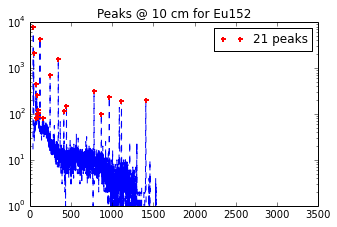


Cs137 
Energy  Counts     Area
661.74   3016   14073.00




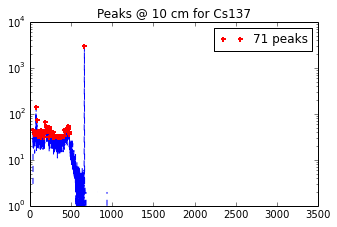

   isotope       line  branchingRatio  measuredCounts  measUncert
0    Cs137   661.6570        0.851000           14073         118
1     Co60  1173.2300        0.998500            4048          65
2     Co60  1332.4900        0.999826            3728          61
3    Eu152   121.7000        0.285300           12334         114
4    Eu152   244.7000        0.075500            2285          51
5    Eu152   344.2900        0.265900            5952          78
6    Eu152   778.9000        0.129300            1508          41
7    Eu152   964.0600        0.145100            1334          38
8    Eu152  1112.0800        0.136700            1167          36
9    Eu152  1408.0100        0.208700            1422          38
10   Ba133    80.9979        0.329000           14126         124
11   Ba133   276.4000        0.071600            1703          42
12   Ba133   356.0100        0.620500           12097         110


In [6]:
# Create a dictionary of data frames to store each of the positional information
peakData={}

for p in posUsed:
    print "\n------------------------"
    print "Position = {} cm".format(p)
    print "------------------------"
    # Update dataframe to store calculated peak information
    lines['measuredCounts']=0     
    lines['measUncert']=0
    for column in data[p]:
        
        # Find the peaks 
        channels=np.asarray(data[p].index)
        energy=eCalibParams[p][2]+eCalibParams[p][1]*channels+eCalibParams[p][0]*channels**2
        counts=np.asarray(data[p][column]).astype(float)
        peaks = peakutils.indexes(counts, thres=0.01, min_dist=10)
        
        # Loop over all identified peaks to compare against calibration points loaded previously
        print "\n", data[p][column].name, "\nEnergy  Counts     Area"      
        for i in range(len(lines['line'])):
            for e,c,pk in zip(energy[peaks],counts[peaks],peaks):
                # Calculate the total peak counts if a calibration peak
                if abs(e-lines['line'][i]) < 1 and data[p][column].name.strip()==lines['isotope'][i].strip():
                    (lines.at[i,'measuredCounts'],lines.at[i,'measUncert'])=peak_counts(channels, counts, pk)
                    print "{:.2f}   {:.0f}   {:.2f}".format(e,c,lines.at[i,'measuredCounts'])
            lines.at[i,'isotope']=lines.at[i,'isotope'].strip()
        print "\n"
        
        # Plot the peaks found
        fig=pyplot.figure(figsize=(5,3))
        ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
        ax1.set_yscale('log')
        pplot(energy, counts, peaks)
        pyplot.title('Peaks @ {} cm for {}'.format(p,data[p][column].name))        
        pyplot.show()
        
    print lines
    peakData[p]=cp.deepcopy(lines)

### Calculate the current activity

Using the data read in from the .spe files, calculate the current activity at the time of the measurement.  

NOTE:  There is a mix in the activity units.  The initActivity is in $\mu$Ci as reported on the source, whereas the curActivity in is Bq.

In [7]:
sources['curActivity']=0
for src in sources.index:
    sources.at[src,'curActivity']=decay(sources.at[src,'halfLife'],sources.at[src,'initActivity'],\
                                        (sources.at[src,'measDate']-sources.at[src,'initDate']).total_seconds())
print sources   

        initActivity   initDate     halfLife             measDate  curActivity
source                                                                        
Am241         10.300 1970-01-01  13644204000  2017-02-08 18:33:23       353379
Eu152          1.062 2009-01-01    426326180  2017-02-08 18:51:12        25923
Co60           1.007 2009-01-01    166344192  2017-02-08 17:55:05        12832
Cs137          1.042 2009-01-01    948723200  2017-02-08 18:57:32        31981
Ba133          1.078 2009-01-01    332778540  2017-02-08 18:47:51        23410


### Calculate absolute effficiency

Determine an absolute efficiency curve for each position by curve fitting the experimental data.

NOTE: The uncertainty only currently captures the uncertainity in the counts.  The uncertaities in BR, half lives, and measurement time are sufficiently small that they can be ignored, but there is uncertainty associated with the fit of the peak that is not captured.  

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


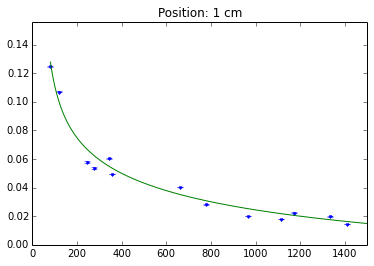

The curve fitting parameters at 1 cm are: [ 0.03279101  0.01462466  0.15007903 -0.0159574 ]
with standard devaiations at 1 of: [ 0.00117239  0.00082269  0.01437807  0.00094663]


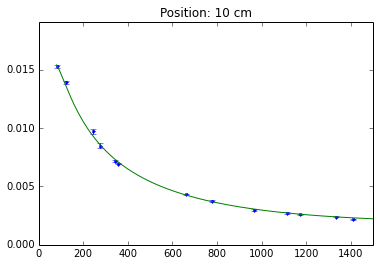

The curve fitting parameters at 10 cm are: [ 0.00971676  0.00569734  0.08527689  0.00269116]
with standard devaiations at 10 of: [ 0.00036941  0.00025712  0.00446328  0.00031308]


In [8]:
absEffParams={}

for p in posUsed:
    peakData[p]['expectedCounts']=0.0
    peakData[p]['absEfficiency']=0.0
    peakData[p]['effUncert']=0.0
    
    for index, row in peakData[p].iterrows():
        peakData[p].at[index,'expectedCounts']=sources.at[peakData[p].at[index,'isotope'],'curActivity'] \
                                               * peakData[p].at[index,'branchingRatio'] \
                                               * liveTime[p][peakData[p].at[index,'isotope']]
        peakData[p].at[index,'absEfficiency']=float(peakData[p].at[index,'measuredCounts']) \
                                               / float(peakData[p].at[index,'expectedCounts'])
        peakData[p].at[index,'effUncert']=peakData[p].at[index,'absEfficiency'] * \
                                           sqrt((float(peakData[p].at[index,'measUncert']) \
                                           / float(peakData[p].at[index,'measuredCounts']))**2)

    # Fit the data for the current position
    popt, pcov = curve_fit(germanium_rel_eff,peakData[p]['line'],peakData[p]['absEfficiency'],\
                            sigma=peakData[p]['effUncert'],absolute_sigma=True)
    absEffParams[p]=popt   

    #Plot the Data
    pyplot.axis([0,1500,0,1.25*max(peakData[p]['absEfficiency'])])
    pyplot.title('Position: {} cm'.format(p))
    pyplot.errorbar(peakData[p]['line'],peakData[p]['absEfficiency'],peakData[p]['effUncert'], fmt='.')
    #Plot the fit
    xlist = np.arange(min(peakData[p]['line']),1.25*max(peakData[p]['line']),1)
    ylist = map(lambda y: germanium_rel_eff(y, popt[0], popt[1], popt[2], popt[3]), xlist)
    pyplot.plot(xlist, ylist)
    pyplot.show()

    print 'The curve fitting parameters at {} cm are: {}'.format(p,absEffParams[p])
    print 'with standard devaiations at {} of: {}'.format(p,np.sqrt(np.diag(pcov))) 

### Set Reference Line

Determine a line to be used as the absolute reference line for all future data as a function of position.  This is done by hand below by determining which data point you have the most confidence in (most collected data), one closest to the lines of interest for the experiment, or one the function fits best (not the best choice).  In a perfect calibration, this choice is irrelevant. 

For this, the 778 keV line from Eu152 was chosen as it lines in the middle of the experimental lines of interest.

In [9]:
refEnergy={}

for pos in posUsed:
    refEnergy[pos]=lines.at[6,'line']

## Experimental Setup